In [1]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

In [2]:
def parse_fasta(filepath):
    seqs = {}
    with open(filepath) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            lengths.append(len(seq_record.seq))
            seqs[seq_record.id]=str(seq_record.seq)
    return seqs

In [3]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
    
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    #ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
    #                                            x, 1))(np.unique(y)))

    ax_scatter.set_xlabel(("Model Fit ABA"), fontsize=15)
    ax_scatter.set_ylabel("In Vivo Log Fold Change", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("Model Fit ABA")
    plt.ylabel("In Vivo Log Fold Change")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y
def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
def create_simple_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(len(perfect_sequence))]
                for coord in coords:
                    row[int(get_position(coord)/9)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [4]:
sequences = parse_fasta('cas13-master-TilingScreens-data/TilingScreens/data/PreProcessingMetaData_data_Cas13d_GFP_library.final.fa')

In [5]:
sequences

{'rc_000001': 'GTATCCCATAGTCCTTAAATTGGGTCG',
 'rc_000002': 'CCTGTGCTTCCTTTGATCTGGGGCATG',
 'rc_000003': 'GACGATATATACCAAGCGAACGTCTGA',
 'rc_000004': 'ACATGGCAAATTTGCCGGTGTCAAACC',
 'rc_000005': 'TATGGTGAATCGTACATACTGTCGCTG',
 'rc_000006': 'ATAGGACAACTGTCTTTCCCAATATAC',
 'rc_000007': 'CCTGTCCTCCACCGTGAAGGCGGCTTG',
 'rc_000008': 'TTTAACGTTATCTGCAGGCGCAGGGGA',
 'rc_000009': 'TGTCAAACAATCTACACAGTAAGTCGC',
 'rc_000010': 'TGATCCCCGGCACTAAGGTGCTGATTC',
 'rc_000011': 'AGCGTAGATCAACCAGCAAGTGCAGCG',
 'rc_000012': 'TGATGCAGGGATGCGTCGGTGAATCCT',
 'rc_000013': 'GAATGCCAACGGGAATCAGCTCCGACT',
 'rc_000014': 'GGGATAACAGGGTCGATGCCGCCCTTA',
 'rc_000016': 'GAGGACGGAATGTATCTACACCATTGG',
 'rc_000017': 'GTATCCTAGAATATGTTCCTCCCAGGT',
 'rc_000018': 'CACACTACCAACGACGCACACCGTTTA',
 'rc_000019': 'GTTCCGACGGATACCGGTGTCTACCGC',
 'rc_000020': 'AATGGTCAGTCCCGTTGATAGACTGTG',
 'rc_000021': 'ACGACTGTCGCACACGCCGTTTATCTC',
 'rc_000022': 'TACTGTTTCAACGAATCACTGCACAAC',
 'rc_000023': 'ATATTACAATAAACGATGGATCGTTTC',
 'rc_00002

In [6]:
RATES_PATH = 'cas13-master-TilingScreens-data/TilingScreens/data/GFP_count_matrix_normalized_batchcorrected.csv'

In [7]:
df = pd.read_csv(RATES_PATH)
df.head()

,SC1_BIN1,SC1_BIN2,SC1_BIN3,SC1_BIN4,SC1_Input,SC2_BIN1,SC2_BIN2,SC2_BIN3,SC2_BIN4,SC2_Input,SC3_BIN1,SC3_BIN2,SC3_BIN3,SC3_BIN4,SC3_Input
crRNA001:1-27,778.444647,297.714679,319.338649,266.081657,455.147812,644.825901,227.333739,190.198970,345.874846,385.563065,779.160448,336.210142,221.579853,253.293220,522.212362
crRNA002:2-28,574.444627,251.833460,215.224495,224.072154,293.258183,549.187516,263.059505,196.420916,217.045457,293.775064,593.976968,203.390156,221.000024,218.076049,287.385918
crRNA003:6-32,434.910550,182.276368,125.990356,176.005013,174.710671,496.447045,225.639307,150.276298,109.971982,245.141463,282.508898,140.917401,178.302582,143.662488,1238.116733
crRNA004:7-33,419.941661,175.990591,169.416112,103.793553,175.989523,496.778969,197.979126,153.669423,123.908298,211.055637,393.909444,120.278801,124.857695,170.163173,246.878780
crRNA004:7-33_consecDouble_01,599.231530,150.908735,117.405077,103.647783,1022.469035,359.829870,8556.604634,102.979233,116.811154,185.816465,329.681315,93.940426,123.696649,128.656496,21626.160350


In [8]:
log_changes = {}
BIN = 2
for i, row in df.iterrows():
    if "FirstOrder_" in i:
        prefix = i.split("_FirstOrder")[0]
        try:
            original = df.loc[prefix]
        except:
            continue
        #print(original)
        mean_original = np.nanmean([np.log(original['SC1_BIN{}'.format(BIN)]/original['SC1_Input']),
                                    np.log(original['SC2_BIN{}'.format(BIN)]/original['SC2_Input']),
                                    np.log(original['SC3_BIN{}'.format(BIN)]/original['SC3_Input'])])
        mean_current = np.nanmean([np.log(row['SC1_BIN{}'.format(BIN)]/row['SC1_Input']),
                                   np.log(row['SC2_BIN{}'.format(BIN)]/row['SC2_Input']),
                                   np.log(row['SC3_BIN{}'.format(BIN)]/row['SC3_Input'])])
        log_changes[i] = mean_current-mean_original

In [9]:
log_changes

{'crRNA004:7-33_FirstOrder_01': 0.7219081131031495,
 'crRNA004:7-33_FirstOrder_02': -0.1236989197120279,
 'crRNA004:7-33_FirstOrder_03': 0.0496054025691306,
 'crRNA004:7-33_FirstOrder_04': 0.09267646122372239,
 'crRNA004:7-33_FirstOrder_05': -1.0156644973501507,
 'crRNA004:7-33_FirstOrder_06': -0.04672866086778282,
 'crRNA004:7-33_FirstOrder_07': 0.12547888628560422,
 'crRNA004:7-33_FirstOrder_08': 0.0026027893837303195,
 'crRNA004:7-33_FirstOrder_09': 0.26097869154508047,
 'crRNA004:7-33_FirstOrder_10': 0.27845604485450637,
 'crRNA004:7-33_FirstOrder_11': 1.0102031376887013,
 'crRNA004:7-33_FirstOrder_12': 0.24060589915945957,
 'crRNA004:7-33_FirstOrder_13': 0.024529648244419083,
 'crRNA004:7-33_FirstOrder_14': -0.7554269771845052,
 'crRNA004:7-33_FirstOrder_15': 0.2783463242674509,
 'crRNA004:7-33_FirstOrder_16': 0.3405792848684257,
 'crRNA004:7-33_FirstOrder_17': -0.35921622588633495,
 'crRNA004:7-33_FirstOrder_18': -0.26257104892299843,
 'crRNA004:7-33_FirstOrder_19': 0.17747940005

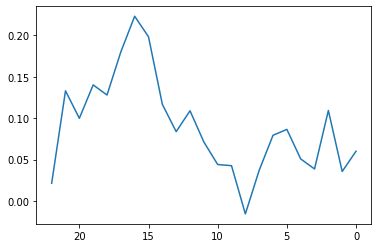

In [10]:
plt.plot([np.mean([log_changes[x] for x in log_changes if int(x[-2:]) == i]) for i in range(1,24)])
plt.gca().invert_xaxis()

In [11]:
def generate_X_y_GFP(sequences, log_changes):
    X = []
    y = []
    for seq in log_changes:
        target_sequence = sequences[seq]
        perfect_match = sequences[seq.split("_FirstOrder")[0]]
        #print(target_sequence, perfect_match)
        coords = get_diff(perfect_match, target_sequence)
        if len(coords) > 5:
            pass
        else:
            dont_count = False
            row = [0 for i in range(9*len(perfect_match))]
            for coord in coords:
                row[get_position(coord)] = 1
                if get_position(coord) >= 9*22:
                    dont_count = True
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            if not dont_count:
                X.append(row)
                y.append(log_changes[seq])
        #print(seq)
    X, y = np.array(X)[:,:198], np.array(y)
    return X, y

In [12]:
X, y = generate_X_y_GFP(sequences, log_changes)

In [13]:
y

array([ 0.72190811, -0.12369892,  0.0496054 , ..., -0.78092577,
       -0.13119421, -0.18222362])

In [14]:
free_energies = pd.read_csv("gfp_free_energies.csv")
free_energies = free_energies.drop("Unnamed: 0", axis=1)

correlation is 0.07553884175584487 p-value 8.533175830097084e-05


Text(0.5, 1.0, 'Log_changes vs Free Energy, Window=40')

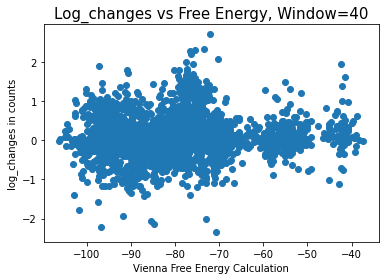

In [15]:
win_0 = free_energies[["name", "window_100"]].set_index('name')['window_100'].to_dict()
x,y = [], []
for name in win_0:
    x.append(win_0[name]), y.append(log_changes[name])
plt.scatter(x, y)
corr, p_value = pearsonr(x, y)
print("correlation is",corr, "p-value", p_value)
plt.ylabel("log_changes in counts")
plt.xlabel("Vienna Free Energy Calculation")
plt.title("Log_changes vs Free Energy, Window=40", fontsize=15)

In [169]:
free_energies

,name,window_0,window_1,window_5,window_10,window_20,window_40,window_100
0,crRNA004:7-33_FirstOrder_01,-5.7,-5.7,-5.7,-9.8,-11.500000,-17.100000,-43.200001
1,crRNA004:7-33_FirstOrder_02,-5.7,-5.7,-7.8,-11.7,-14.600000,-18.799999,-41.799999
2,crRNA004:7-33_FirstOrder_03,-5.7,-5.7,-5.8,-10.5,-13.400000,-17.400000,-41.000000
3,crRNA004:7-33_FirstOrder_04,-5.7,-5.7,-5.8,-10.5,-13.400000,-17.400000,-40.000000
4,crRNA004:7-33_FirstOrder_05,-5.7,-5.7,-6.1,-10.5,-13.400000,-17.400000,-45.200001
...,...,...,...,...,...,...,...,...
2695,crRNA400:688-714_FirstOrder_23,-5.8,-6.0,-6.0,-8.1,-13.900000,-19.600000,-53.900002
2696,crRNA400:688-714_FirstOrder_24,-1.0,-1.0,-1.0,-5.6,-10.200000,-18.600000,-49.900002
2697,crRNA400:688-714_FirstOrder_25,-3.3,-3.7,-4.3,-9.2,-16.200001,-21.900000,-53.400002
2698,crRNA400:688-714_FirstOrder_26,-3.2,-3.8,-4.4,-7.2,-11.800000,-18.400000,-51.099998


# Compare to earlier linear model

In [111]:
# Time to load in the data
data2 = pd.read_csv("../data2.csv")
energies2 = pd.read_csv("../subopt_attributes7.csv")
energies2["sequence"] = energies2.Sequence.str.slice(29, -32).str.replace("U", "T")
windows2 = pd.read_csv("../vienna_windows7.csv")
windows2["sequence"] = windows2['0'].str.slice(29, -32).str.replace("U", "T")
big_table2 = pd.merge(energies2, data2, on='sequence', how="inner")
big_table2 = pd.merge(big_table2, windows2, on='sequence', how="inner")
#big_table = data
#columns list needed when we add data later
cols2 = list(energies2.columns)
cols2.remove('Sequence')
cols2.remove('sequence')



#now we want to add the ABA column to big_table
perfect_sequence2 = "TTTGATCTGAAATATTCAGGTC"
PERFECT_KD2 = big_table2[big_table2['sequence'] == perfect_sequence2].iloc[0]['kd']
#PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table2['ABA'] = (big_table2.kd/PERFECT_KD2).apply(np.log)
big_table2.head()

##########################
#other table
#########################
# Time to load in the data
data1 = pd.read_csv("../data.csv")
energies1 = pd.read_csv("../subopt_attributes.csv")
energies1 = energies1.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies1["sequence"] = energies1.Sequence.str.slice(29, -32).str.replace("U", "T")
windows1 = pd.read_csv("../vienna_windows4.csv")
windows1["sequence"] = windows1['0'].str.slice(29, -32).str.replace("U", "T")
big_table1 = pd.merge(energies1, data1, on='sequence', how="inner")
big_table1 = pd.merge(big_table1, windows1, on='sequence', how="inner")

#columns list needed when we add data later
cols1 = list(energies1.columns)
cols1.remove('Sequence')
cols1.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence1 = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['kd']
PERFECT_SEQ1 = big_table1[big_table1['sequence'] == perfect_sequence1].iloc[0]['Sequence']
big_table1['ABA'] = (big_table1.kd/PERFECT_KD1).apply(np.log)
big_table1.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,...,delta_y,count,0,0.1,1,5,10,20,40,ABA
0,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,...,69772.0,54,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,-9.7,-9.7,-9.7,-13.3,-15.3,-21.9,3.808252
1,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,...,69772.0,80,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,-2.8,-2.8,-2.8,-5.4,-12.1,-23.9,3.678871
2,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,...,69772.0,61,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,-2.9,-2.9,-3.2,-7.7,-9.3,-15.5,1.997113
3,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,...,69772.0,66,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,-0.7,-1.1,-1.5,-5.8,-13.2,-19.5,4.926277
4,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,...,69772.0,74,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,-1.1,-1.1,-1.5,-5.7,-11.1,-15.7,4.811688


In [112]:
X1, y1 = create_matrix(big_table1, perfect_sequence1)
X2, y2 = create_matrix(big_table2, perfect_sequence2)
X, y = (np.concatenate((X1,X2), axis=0), np.concatenate((y1,y2), axis=0))
X, y = shuffle(X, y)
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [125]:
X, y = create_matrix(big_table1, perfect_sequence1)
X, y = shuffle(X, y)
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1)

In [142]:
X_prime, y_prime = generate_X_y_GFP(sequences, log_changes)

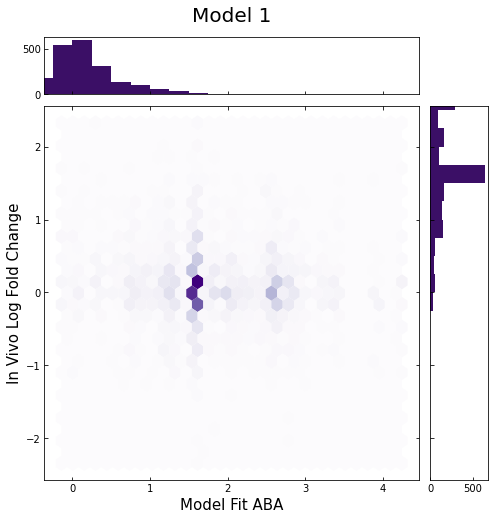

correlation is -0.0775210965993438 p-value 0.00027319664097523504


In [143]:
predicted_output = X_prime @ reg.coef_ + reg.intercept_
display(y_prime,vhinge(predicted_output),  title="Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y_prime)
print("correlation is",corr, "p-value", p_value)

# Compare to random

In [144]:
def hist_of_random_weights(X, y, gaussian=True, n=100):
    correlations, pvals = [],[]
    for i in range(n):
        if gaussian:
            random_weights = np.random.normal(size=X.shape[1])
            corr, p_value = pearsonr(X @ random_weights, y)
            correlations.append(corr)
            pvals.append(p_value)
            #print("correlation is",corr, "p-value", p_value)
        else:
            random_weights = np.random.normal(size=X.shape[1])
            corr, p_value = pearsonr(X @ random_weights, y)
            correlations.append(corr)
            pvals.append(p_value)
            #print("correlation is",corr, "p-value", p_value)
    return correlations, pvals

In [145]:
corrs, pvals= hist_of_random_weights(X_prime, y_prime, gaussian=True, n = 10000)

In [146]:
min(pvals)

8.532739959306923e-06

In [147]:
np.percentile(pvals, 1)

0.009672515361893532

(array([2214., 1283.,  986.,  874.,  829.,  770.,  789.,  769.,  700.,
         786.]),
 array([1.70217033e-07, 9.99839733e-02, 1.99967776e-01, 2.99951580e-01,
        3.99935383e-01, 4.99919186e-01, 5.99902989e-01, 6.99886792e-01,
        7.99870595e-01, 8.99854398e-01, 9.99838201e-01]),
 <BarContainer object of 10 artists>)

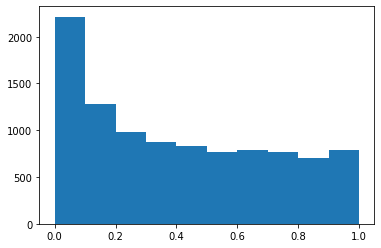

In [71]:
plt.hist(pvals)

In [150]:
X.shape

(4793, 198)